In [1]:
import pandas as pd
from pybedtools import BedTool
import re
import matplotlib.pyplot as plt
import seaborn as sns


DIR = "/pollard/home/sandyfloren/hierarchical"

# ENCODE bed narrowPeak format
# This format is used to provide called peaks of signal enrichment based on pooled, normalized (interpreted) data. It is a BED6+4 format.
# 1. chrom - Name of the chromosome (or contig, scaffold, etc.).
# 2. chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.
# 3. chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature. For example, the first 100 bases of a chromosome are defined as chromStart=0, chromEnd=100, and span the bases numbered 0-99.
# 4. name - Name given to a region (preferably unique). Use "." if no name is assigned.
# 5. score - Indicates how dark the peak will be displayed in the browser (0-1000). If all scores were "'0"' when the data were submitted to the DCC, the DCC assigned scores 1-1000 based on signal value. Ideally the average signalValue per base spread is between 100-1000.
# 6. strand - +/- to denote strand or orientation (whenever applicable). Use "." if no orientation is assigned.
# 7. signalValue - Measurement of overall (usually, average) enrichment for the region.
# 8. pValue - Measurement of statistical significance (-log10). Use -1 if no pValue is assigned.
# 9. qValue - Measurement of statistical significance using false discovery rate (-log10). Use -1 if no qValue is assigned.
# 10. peak - Point-source called for this peak; 0-based offset from chromStart. Use -1 if no point-source called.

thresholded_peaks = BedTool(f"{DIR}/data/encode_heart/atac/GSE215505_ENCFF811VNG_IDR_thresholded_peaks_GRCh38.bed")

In [2]:
genes = BedTool(f"{DIR}/data/gencode/gencode.v46.annotation_genes.gtf")

In [4]:
CHUNK_SIZE = 2000
window_sizes = [5e5]#[5e5, 1e6, 2e6, 4e6]
window_dfs = {}
chunk_dfs = {}

for window_size in window_sizes: 
    gene_names = []
    chrs = []
    starts = []
    ends = []
    gene_lengths = []
    gene_types = []

    chunk_dict = {}
    n_chunks = 0
    for gene in genes:
        gene_name = re.search(r'gene_name\s\"(.*?)\"', gene[8]).group(1)
        gene_type = re.search(r'gene_type\s\"(.*?)\"', gene[8]).group(1)
        chr = gene[0]
        start = max(int(gene[3]) - int(window_size // 2), 0)
        end = int(gene[3]) + int(window_size // 2)
        gene_length = int(gene[4]) - int(gene[3])

        gene_names.append(gene_name)
        gene_types.append(gene_type)
        chrs.append(chr)
        starts.append(str(start))
        ends.append(str(end))
        gene_lengths.append(gene_length)

        chunks = range(start, end, CHUNK_SIZE)
        chunk_dict[(gene_name, gene_length, gene_type, chr)] = chunks
        n_chunks += len(chunks)

    # Window-level coverage
    string = ''
    for i in range(len(gene_names)):
        string += ' '.join((chrs[i], starts[i], ends[i])) + '\n'

    windows = BedTool(string, from_string=True)
    window_coverage = windows.coverage(thresholded_peaks)
    window_df = window_coverage.to_dataframe(disable_auto_names=True, header=None)
    window_df.columns = ['chrom', 'start', 'end', 'num_peaks', 'length_overlap', 'window_length', 'prop_overlap']
    window_df['gene_name'] = gene_names
    window_df['gene_length'] = gene_lengths
    window_df['gene_type'] = gene_types
    window_df = window_df[window_df['chrom'] != 'chrM']

    window_dfs[window_size] = window_df

    # Chunk-level coverage
    string = ''
    for (gene_name, gene_length, gene_type, chr), chunks in chunk_dict.items():
        for i in range(len(chunks)-1):
            string += ' '.join((chr, str(chunks[i]), str(chunks[i+1]), gene_name, str(gene_length), gene_type)) + '\n'
    
    chunks = BedTool(string, from_string=True)
    #chunk_coverage = chunks.coverage(thresholded_peaks)
    #chunk_df = chunk_coverage.to_dataframe(disable_auto_names=True, header=None)
    #chunk_df.columns = ['chrom', 'start', 'end', 'gene_name', 'gene_length', 'gene_type', 'num_peaks', 'length_overlap', 'window_length', 'prop_overlap']
    #chunk_df = chunk_df[chunk_df['chrom'] != 'chrM']

    #chunk_dfs[window_size] = chunk_df


KeyboardInterrupt: 

In [204]:
for window_size in window_sizes:
    window_dfs[window_size].to_csv(f"{DIR}/bin/objects/atac_peaks_in_windows_{window_size}.csv", index=False)

<Axes: xlabel='num_peaks', ylabel='Count'>

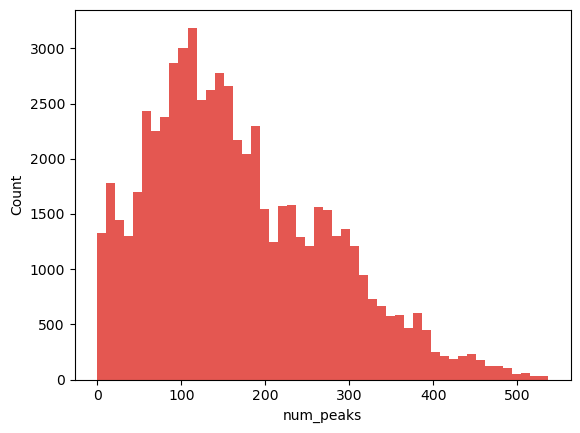

In [10]:
df = pd.read_csv(f"{DIR}/bin/objects/atac_peaks_in_windows_4000000.0.csv")
df

sns.histplot(
    data=df,
    x='num_peaks',
    color='#de2d26',
    alpha=0.8,
    bins=50,
    edgecolor=None
    )

In [210]:
window_dfs[5e5]

,chrom,start,end,num_peaks,length_overlap,window_length,prop_overlap,gene_name,gene_length,gene_type
0,chr1,0,261869,0,0,261869,0.0,DDX11L2,2540,lncRNA
1,chr1,0,262010,0,0,262010,0.0,DDX11L1,1660,transcribed_unprocessed_pseudogene
2,chr1,0,264696,0,0,264696,0.0,WASH7P,10190,unprocessed_pseudogene
3,chr1,0,267369,0,0,267369,0.0,MIR6859-1,67,miRNA
4,chr1,0,279554,0,0,279554,0.0,MIR1302-2HG,1555,lncRNA
...,...,...,...,...,...,...,...,...,...,...
63044,chrY,56934216,57434216,0,0,500000,0.0,IL9R,13121,protein_coding
63045,chrY,56940738,57440738,0,0,500000,0.0,ENSG00000292369,18018,lncRNA
63046,chrY,56951143,57451143,0,0,500000,0.0,WASIR1,2214,lncRNA
63047,chrY,56957346,57457346,0,0,500000,0.0,WASH6P,4884,protein_coding


In [ ]:
sns.histplot(
    data=window_dfs[5e5][is_protein_coding],
    x='prop_overlap',
    color='#de2d26',
    alpha=0.8,
    bins=50,
    edgecolor=None,
    label='Protein coding genes'
    )

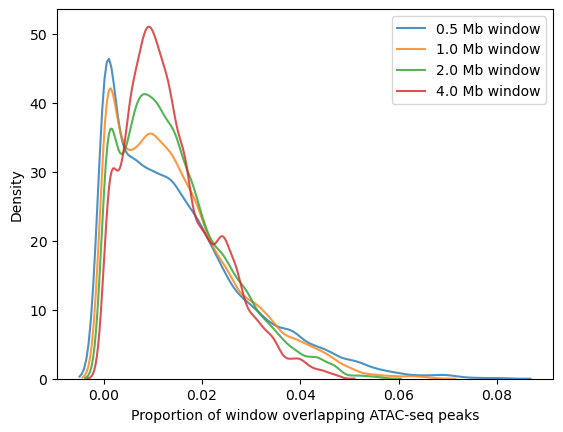

In [216]:
is_protein_coding = window_dfs[5e5]['gene_type'] == 'protein_coding'
sns.kdeplot(
    data=window_dfs[5e5][~is_protein_coding],
    x='prop_overlap',
    #color='',
    alpha=0.8,
    label='0.5 Mb window'
    )
sns.kdeplot(
    data=window_dfs[1e6][~is_protein_coding],
    x='prop_overlap',
    #color='#3182bd',
    alpha=0.8,
    label='1.0 Mb window'
    )
sns.kdeplot(
    data=window_dfs[2e6][~is_protein_coding],
    x='prop_overlap',
    #color='#3182bd',
    alpha=0.8,
    label='2.0 Mb window'
    )
sns.kdeplot(
    data=window_dfs[4e6][~is_protein_coding],
    x='prop_overlap',
    #color='#3182bd',
    alpha=0.8,
    label='4.0 Mb window'
    )

plt.xlabel('Proportion of window overlapping ATAC-seq peaks')
plt.legend()
plt.show()


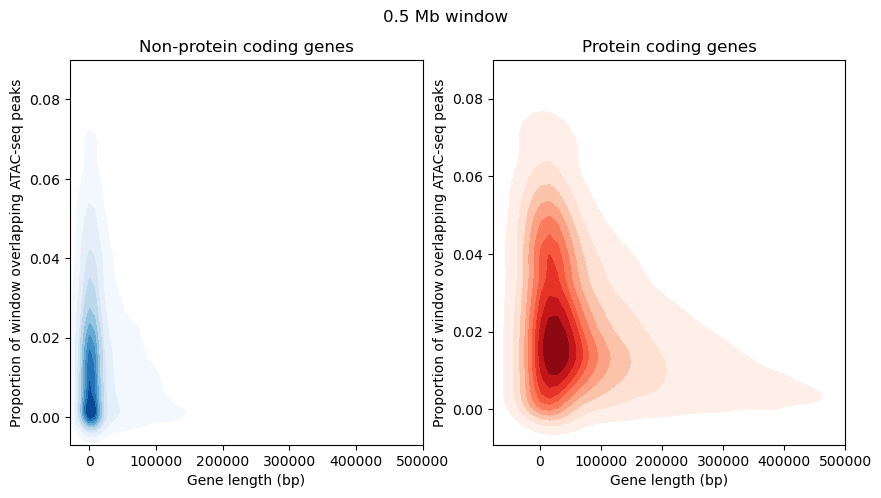

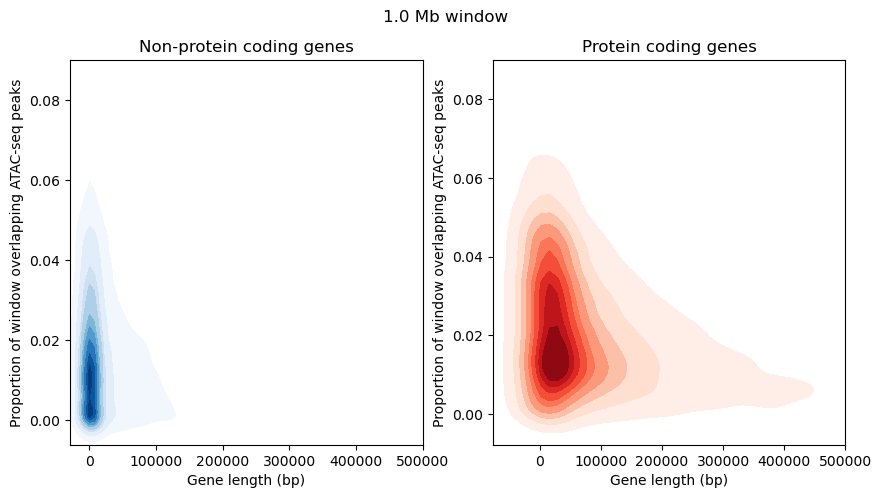

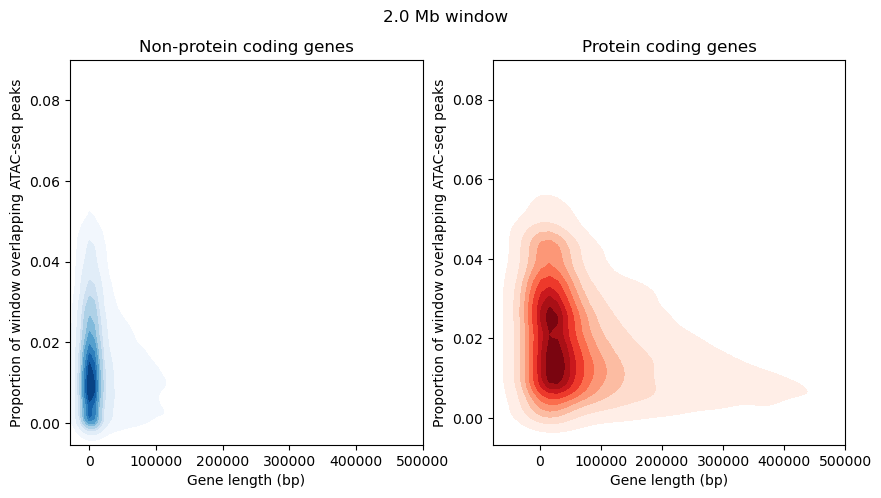

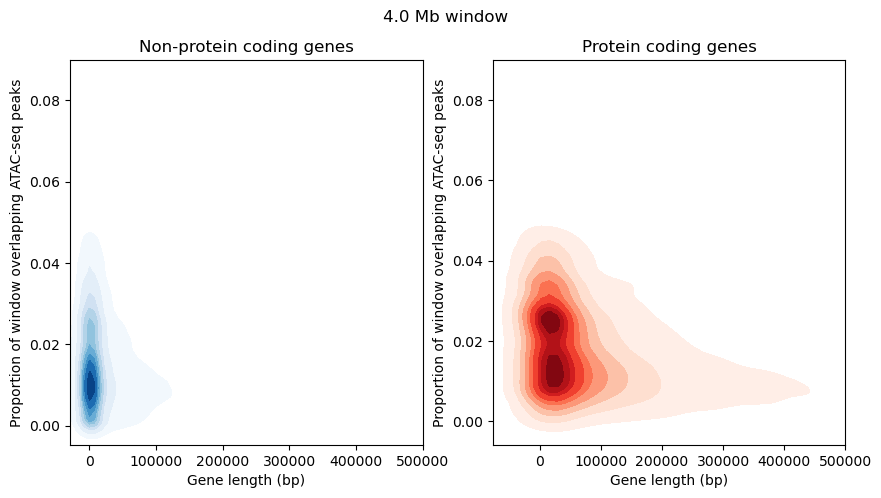

In [228]:
def plot_densities(df, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.kdeplot(
        ax=axs[0],
        data=df[~is_protein_coding],
        x='gene_length', 
        y='prop_overlap',
        fill=True,
        cmap='Blues',
        alpha=1,
        label='Non-protein coding'
        )
    sns.kdeplot(
        ax=axs[1],
        data=df[is_protein_coding],
        x='gene_length', 
        y='prop_overlap',
        fill=True,
        cmap='Reds',
        alpha=1,
        label='Protein coding'
        )
    axs[0].set_xlim(right=5e5)
    axs[0].set_xlabel('Gene length (bp)')
    axs[0].set_ylim(top=0.09)
    axs[0].set_ylabel('Proportion of window overlapping ATAC-seq peaks')
    axs[0].set_title('Non-protein coding genes')

    axs[1].set_xlim(right=5e5)
    axs[1].set_xlabel('Gene length (bp)')
    axs[1].set_ylim(top=0.09)
    axs[1].set_ylabel('Proportion of window overlapping ATAC-seq peaks')
    axs[1].set_title('Protein coding genes')

    fig.suptitle(title)
    plt.show()


plot_densities(window_dfs[5e5], '0.5 Mb window')
plot_densities(window_dfs[1e6], '1.0 Mb window')
plot_densities(window_dfs[2e6], '2.0 Mb window')
plot_densities(window_dfs[4e6], '4.0 Mb window')